In [1]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
# from tensorflow.keras.layers.advanced_activations import LeakyReLU
# from tensorflow.keras.layers.convolutional import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop,Adam

import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

import sys
import sklearn.datasets

import numpy as np
from functools import partial
import random

from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import auc,roc_curve, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report,f1_score
from scipy.stats import norm
from sklearn import preprocessing

In [2]:
from scipy.stats import multivariate_normal
mean = (5, 5)
cov = [[5, 0], [0, 5]]
normal_data = np.random.multivariate_normal(mean,cov,30000)
vandal_data_1 = np.random.multivariate_normal((0,0),[[0.6,0],[0,0.5]],50)
vandal_data_2 = np.random.multivariate_normal((0,10),[[0.6,0],[0,0.5]],50)
vandal_data_3 = np.random.multivariate_normal((10,0),[[0.6,0],[0,0.5]],50)
vandal_data_4 = np.random.multivariate_normal((10,10),[[0.6,0],[0,0.5]],50)
train_normal_data = normal_data[:15000]
test_normal_data = normal_data[15000:]
train_vandal_data = np.vstack((vandal_data_1[:20],vandal_data_2[:20],vandal_data_3[:20],vandal_data_4[:20]))
test_vandal_data = np.vstack((vandal_data_1[20:],vandal_data_2[20:],vandal_data_3[20:],vandal_data_4[20:]))

In [3]:
train_normal_label = np.zeros(len(train_normal_data))
train_vandal_label = np.ones(len(train_vandal_data))

train_data_x = np.vstack((train_normal_data,train_vandal_data))
train_data_y = np.hstack((train_normal_label,train_vandal_label))

test_normal_label = np.zeros(len(test_normal_data))
test_vandal_label = np.ones(len(test_vandal_data))
test_data_x = np.vstack((test_normal_data,test_vandal_data))
test_data_y = np.hstack((test_normal_label,test_vandal_label))

print(train_data_x.shape,train_data_y.shape,test_data_x.shape,test_data_y.shape)

(15080, 2) (15080,) (15120, 2) (15120,)


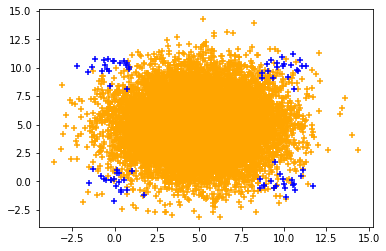

In [4]:

plt.scatter(train_normal_data[:, 0], train_normal_data[:, 1], c='orange',  marker='+')
plt.scatter(train_vandal_data[:, 0], train_vandal_data[:, 1], c='blue',  marker='+')
plt.show()

# DevNet

In [5]:
import random
# Dataset iterator
def inf_normal_train_gen(BATCH_SIZE,x_normal_data):
    while True:
#         np.random.shuffle(x_normal_data)
        for i in range(int(len(x_normal_data)/BATCH_SIZE)):
            yield x_normal_data[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            
# Dataset iterator
def inf_vandal_train_gen(BATCH_SIZE,x_vandal_data):
    while True:
        np.random.shuffle(x_vandal_data)
        dataset = []
        for i in range(BATCH_SIZE):
            dataset.append(random.choice(x_vandal_data))
        dataset = np.array(dataset, dtype='float32')
        yield dataset

In [6]:
def deviation_loss(y_true, y_pred):
    '''
    z-score-based deviation loss
    '''    
    confidence_margin = 5.     
    ## size=5000 is the setting of l in algorithm 1 in the paper
    ref = K.variable(np.random.normal(loc = 0., scale= 1.0, size = 5000) , dtype='float32')
    dev = (y_pred - K.mean(ref)) / K.std(ref)
    inlier_loss = K.abs(dev) 
    outlier_loss = K.abs(K.maximum(confidence_margin - dev, 0.))
    return (1 - y_true) * inlier_loss + y_true * outlier_loss

In [7]:
def network(input_shape):
    '''
    network architecture with one hidden layer
    '''
    x_input = Input(shape=input_shape)
    intermediate = Dense(20, activation='relu', 
                kernel_regularizer=regularizers.l2(0.01), name = 'hl1')(x_input)
    intermediate = Dense(1, activation='linear',  name = 'score')(intermediate)    
    return Model(x_input, intermediate)

In [8]:
def anomaly_score_learner(input_shape):
    '''
    construct the deviation network-based detection model
    '''
    model = network(input_shape)
    rms = RMSprop(clipnorm=1.)
    model.compile(loss=deviation_loss, optimizer=rms)
    return model

In [9]:
def sample_shuffle_spv(X, labels):
    n_samples = len(X)
    s = np.arange(n_samples)
    np.random.shuffle(s)
    return np.array(X[s]), labels[s]

In [10]:
def sample_shuffle_uspv(X, labels, weights):
#     print(X.shape,labels.shape,weights.shape)
    n_samples = len(X)
    s = np.arange(n_samples)
    np.random.shuffle(s)
    return np.array(X[s]), labels[s], weights[s]

In [11]:
def input_batch_generation_sup(x_train, outlier_indices, inlier_indices, batch_size, rng):
    '''
    batchs of samples. This is for csv data.
    Alternates between positive and negative pairs.
    '''      
    dim = x_train.shape[1]
    ref = np.empty((batch_size, dim))    
    training_labels = []
    n_inliers = len(inlier_indices)
    n_outliers = len(outlier_indices)
    for i in range(batch_size):    
        if(i % 2 == 0):
            sid = rng.choice(n_inliers, 1)
            ref[i] = x_train[inlier_indices[sid]]
            training_labels += [0]
        else:
            sid = rng.choice(n_outliers, 1)
            ref[i] = x_train[outlier_indices[sid]]
            training_labels += [1]
    return np.array(ref), np.array(training_labels)


def batch_generator_sup(x, outlier_indices, inlier_indices, batch_size, nb_batch, rng):
    """batch generator
    """
    rng = np.random.RandomState(rng.randint(MAX_INT, size = 1))
    counter = 0
    while 1:                
        ref, training_labels = input_batch_generation_sup(x, outlier_indices, inlier_indices, batch_size, rng)
        counter += 1
        yield(ref, training_labels)
        if (counter > nb_batch):
#             print(counter)
            counter = 0

In [12]:
all_res = []
for run in range(1):
    model = deviation_network(2)
    train_data_x, train_data_y = sample_shuffle_spv(train_data_x, train_data_y)
    test_data_x, test_data_y = sample_shuffle_spv(test_data_x, test_data_y)
    MAX_INT = np.iinfo(np.int32).max
    outlier_indices = np.where(train_data_y == 1)[0]
    inlier_indices = np.where(train_data_y == 0)[0]
    rng = np.random.RandomState(42)
    nb_batch = int(len(train_data_x)/128)
    model.fit_generator(batch_generator_sup(train_data_x, outlier_indices, inlier_indices, 256, nb_batch, rng),steps_per_epoch = nb_batch,
                                              epochs = 30) 
    scores = model.predict(test_data_x)
    test_out = np.int64(scores>=norm.ppf(0.999))
    conf_mat = classification_report(test_data_y, test_out, target_names=['benign', 'vandal'], digits=4)
    print(conf_mat)
    cm = confusion_matrix(test_data_y, test_out, labels=[0, 1])
    m = list(filter(None, conf_mat.strip().split(" ")))
    precision, recall, threshold = precision_recall_curve(test_data_y, scores)
    pr_auc = auc(recall, precision) 
    res = [cm[0][0],cm[0][1],cm[1][0],cm[1][1],roc_auc_score(test_data_y,scores),pr_auc,np.sqrt(float(m[6])*float(m[11]))]
    print(res)
    all_res.append(res)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch 1/30
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
117/117 [==============================] - 2s 20ms/step - loss: 3.7421
Epoch 2/30
117/117 [==============================] - 1s 11ms/step - loss: 2.0452
Epoch 3/30
117/117 [==============================] - 1s 11ms/step - loss: 1.6179
Epoch 4/30
117/117 [==============================] - 1s 10ms/step - loss: 1.4989
Epoch 5/30
117/117 [==============================] - 1s 11ms/step - loss: 1.3930
Epoch 6/30
117/117 [==============================] - 1s 11ms/step - loss: 1.3488: 0s - loss: 1 - ETA: 0s - loss: 1.
Epoch 7/30
117/117 [==============================] - 1s 11ms/step - loss: 1.2847
Epoch 8/30
117/117 [==============================] - 1s 11ms/step - loss: 1.2269
Epoch 9/30
117/117 [==============================] - 1s 11ms/step - loss: 1.1425
Epoch 10/30
117/117 [==============================]

In [13]:
np.mean(all_res,axis =0)

array([1.41990000e+04, 8.01000000e+02, 4.00000000e+00, 1.16000000e+02,
       9.85417778e-01, 2.48431639e-01, 9.56597209e-01])

##### 训练集可视化

In [14]:
scores = model.predict(train_data_x)
test_out = np.int64(scores>=norm.ppf(0.999))
conf_mat = classification_report(train_data_y, test_out, target_names=['benign', 'vandal'], digits=4)
print(conf_mat)
cm = confusion_matrix(train_data_y, test_out, labels=[0, 1])
m = list(filter(None, conf_mat.strip().split(" ")))
precision, recall, threshold = precision_recall_curve(train_data_y, scores)
pr_auc = auc(recall, precision) 
res = [cm[0][0],cm[0][1],cm[1][0],cm[1][1],roc_auc_score(train_data_y,scores),pr_auc,np.sqrt(float(m[6])*float(m[11]))]
print(res)

              precision    recall  f1-score   support

      benign     0.9999    0.9436    0.9709     15000
      vandal     0.0854    0.9875    0.1572        80

    accuracy                         0.9438     15080
   macro avg     0.5427    0.9656    0.5641     15080
weighted avg     0.9951    0.9438    0.9666     15080

[14154, 846, 1, 79, 0.9845991666666667, 0.15892604180496148, 0.96530047135594]


###### 测试集可视化

In [18]:
scores = model.predict(test_data_x)
test_out = np.int64(scores>=norm.ppf(0.999))
conf_mat = classification_report(test_data_y, test_out, target_names=['benign', 'vandal'], digits=4)
print(conf_mat)
cm = confusion_matrix(test_data_y, test_out, labels=[0, 1])
m = list(filter(None, conf_mat.strip().split(" ")))
precision, recall, threshold = precision_recall_curve(test_data_y, scores)
pr_auc = auc(recall, precision) 
res = [cm[0][0],cm[0][1],cm[1][0],cm[1][1],roc_auc_score(test_data_y,scores),pr_auc,np.sqrt(float(m[6])*float(m[11]))]
print(res)

              precision    recall  f1-score   support

      benign     0.9997    0.9466    0.9724     15000
      vandal     0.1265    0.9667    0.2237       120

    accuracy                         0.9468     15120
   macro avg     0.5631    0.9566    0.5981     15120
weighted avg     0.9928    0.9468    0.9665     15120

[14199, 801, 4, 116, 0.9854177777777777, 0.24843163936386395, 0.9565972088606574]


In [19]:
true_positive_index = np.where((test_data_y == 1))[0]
true_negative_index = np.where((test_data_y == 0))[0]
print(true_positive_index.shape,true_negative_index.shape)
predict_positive_index = np.where((test_out == 1))[0]
test_FP_index = []
test_TP_index = []
for i in predict_positive_index:
    if i not in true_positive_index:
        test_FP_index.append(i)
    else:
        test_TP_index.append(i)
print(len(test_FP_index),len(test_TP_index))

predict_negative_index = np.where((test_out == 0))[0]
test_FN_index = []
test_TN_index = []
for i in predict_negative_index:
    if i not in true_negative_index:
        test_FN_index.append(i)
    else:
        test_TN_index.append(i)
print(len(test_FN_index),len(test_TN_index))

(120,) (15000,)
801 116
4 14199


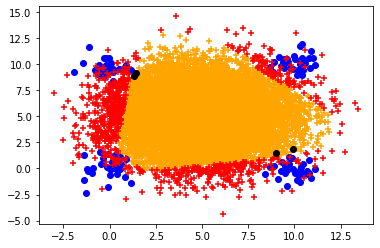

In [20]:
plt.scatter(test_data_x[test_TN_index, 0], test_data_x[test_TN_index, 1], c='orange',  marker='+')
plt.scatter(test_data_x[test_TP_index, 0], test_data_x[test_TP_index, 1], c='blue',  marker='o')
plt.scatter(test_data_x[test_FP_index, 0], test_data_x[test_FP_index, 1], c='red',  marker='+')
plt.scatter(test_data_x[test_FN_index, 0], test_data_x[test_FN_index, 1], c='black',  marker='o')
plt.show()

# PIA-WAL

In [59]:
def inf_hard_normal_weight_train_gen(BATCH_SIZE,normal_scores,normal_data_):
    indicator = np.sign(np.abs(normal_scores) - 5.0)
    condition = np.greater(indicator, np.zeros_like(indicator))
    mask_tar = np.where(condition, np.zeros_like(indicator),np.tanh(np.abs(normal_scores)))
    dataset = []
    weights = []
    while True:
        for idx in range(len(normal_data_)):
            tar = random.random()
            if mask_tar[idx]>tar:
                dataset.append(normal_data_[idx])
                weights.append(np.abs(normal_scores[idx]))
            if len(dataset)==BATCH_SIZE:
                dataset = np.array(dataset, dtype='float32')
                weights = np.array(weights, dtype='float32')
#                 print(i)
                yield dataset,weights
                dataset = []
                weights = []

In [60]:
class WGANGP():
    def __init__(self):
        self.latent_dim = 2
        self.input_dim = 2
        self.n_critic = 5
        self.batch_size = 256
        optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.9)
        self.generator = self.build_generator()
        self.critic = self.build_critic()
        
        self.generator.trainable = False
        
        real_data = Input(shape = (self.input_dim,))
        z_disc = Input(shape = (self.latent_dim,))
        hard_weight = Input(shape = (1,))
        
        fake_data = self.generator(z_disc)
        
        disc_real = self.critic(real_data) * hard_weight
        disc_fake = self.critic(fake_data) * hard_weight
        
        alpha = K.random_uniform([self.batch_size,1], 0, 1)
        interpolates = alpha * real_data  + (1 - alpha) * fake_data 
        disc_interpolates = self.critic(interpolates)
        partial_gp_loss = partial(self.gradient_penalty_loss,averaged_samples=interpolates, hard_weight_=hard_weight)
        partial_gp_loss.__name__ = 'gradient_penalty'
        
        self.critic_model = Model(inputs=[real_data,z_disc,hard_weight],
                                  outputs=[disc_real,disc_fake,disc_interpolates])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                        self.wasserstein_loss,
                                        partial_gp_loss],optimizer=optimizer,
                                        loss_weights=[1, 1, 0.1])
        
        self.critic.trainable = False
        self.generator.trainable = True
        
        z_gen = Input(shape=(self.latent_dim,))
        generate_data = self.generator(z_gen)
        disc_generate = self.critic(generate_data)
        self.generator_model = Model(z_gen,disc_generate)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)
        
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples,hard_weight_):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(hard_weight_ * gradient_penalty)
    
    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_pred * y_true)
    
    def build_generator(self):
        model = Sequential()
        model.add(Dense(512,activation="relu",input_dim=self.latent_dim))
        model.add(Dense(512,activation="relu"))
        model.add(Dense(512,activation="relu"))
        model.add(Dense(2,activation="linear"))
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        output = model(noise)
        
        return Model(noise,output)
    
    def build_critic(self):
        model = Sequential()
        model.add(Dense(512,activation="relu",input_dim=self.input_dim))
        model.add(Dense(512,activation="relu"))
        model.add(Dense(512,activation="relu"))
        model.add(Dense(1,activation="linear"))
        model.summary()
        
        inputs = Input(shape=(self.input_dim,))
        output = model(inputs)
        
        return Model(inputs,output)
    
    def inf_train_gen(self,BATCH_SIZE):
        while True:
            data = sklearn.datasets.make_swiss_roll(
                n_samples=BATCH_SIZE, 
                noise=0.25
            )[0]
            data = data.astype('float32')[:, [0, 2]]
            data /= 7.5 # stdev plus a little
            yield data
    
    def train(self, epochs, batch_size, weight_model,x):
        np.random.shuffle(x)
        x_scores = weight_model.predict(x)
        gen = inf_hard_normal_weight_train_gen(batch_size, x_scores, x)
        real_label = -np.ones((batch_size,1))
        fake_label = np.ones((batch_size,1))
        dummy = np.zeros((batch_size,1))
        for epoch in range(epochs):
            for _ in range(self.n_critic):
                _data,_weight = gen.__next__()
                _noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                d_loss = self.critic_model.train_on_batch([_data, _noise, _weight],
                                                                [real_label, fake_label, dummy])
                
            g_loss = self.generator_model.train_on_batch(_noise, real_label)
            
        print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
        return d_loss[0]

In [61]:
random_seed = 42
MAX_INT = np.iinfo(np.int32).max
all_res_4 = []
d_loss_list = []
disc_loss_list = []
all_loss_list = []
for run in np.arange(1):
    rng = np.random.RandomState(random_seed)
    input_shape = train_data_x.shape[1:]
    
    epochs = 30
    batch_size = 128
    nb_batch = int(len(train_data_x)/batch_size)
    model = deviation_network(input_shape)
    gen_normal = inf_normal_train_gen(batch_size,train_normal_data)
    gen_vandal = inf_vandal_train_gen(batch_size,train_vandal_data)
    min_loss = MAX_INT
    wgan = WGANGP()
    for i in range(30):
        print(str(i)+'*'*20)
        if i !=0:
            disc_loss = np.abs(wgan.train(epochs=200, batch_size=256,weight_model=model, x = train_normal_data))
            generator_quality = np.exp(-disc_loss)
        else:
            disc_loss = 0
        for j in range(nb_batch):
            normal_data_batch = gen_normal.__next__()
            normal_data_label = np.zeros((batch_size,1))
            normal_data_weight = np.ones(batch_size)
            vandal_data_batch = gen_vandal.__next__()
            vandal_data_label = np.ones((batch_size,1))
            vandal_data_weight = np.ones(batch_size)
            
            if i == 0: ###修改了这里
                data_batch = np.vstack((normal_data_batch,vandal_data_batch))
                data_label = np.vstack((normal_data_label,vandal_data_label))
                data_weight = np.hstack((normal_data_weight,vandal_data_weight))
                
            else:
                _noise = np.random.normal(0, 1, (int(batch_size/2), 2))## 真实正常和生成正常各占一半
                fake_data_batch = wgan.generator.predict(_noise)
                fake_data_label = np.zeros((int(batch_size/2),1))
                fake_data_weight = generator_quality * np.ones(int(batch_size/2))
                data_batch = np.vstack((normal_data_batch[:int(batch_size/2)],vandal_data_batch,fake_data_batch))
                data_label = np.vstack((normal_data_label[:int(batch_size/2)],vandal_data_label,fake_data_label))
                data_weight = np.hstack((normal_data_weight[:int(batch_size/2)],vandal_data_weight,fake_data_weight))
                
            data_batch, data_label,data_weight = sample_shuffle_uspv(data_batch,data_label,data_weight)
            #给样本加入权重
            d_loss = model.train_on_batch(data_batch, data_label,sample_weight = data_weight)
        
        print(d_loss)
        scores = model.predict(test_data_x)
        test_out = np.int64(scores>=norm.ppf(0.999))
        conf_mat = classification_report(test_data_y, test_out, target_names=['benign', 'vandal'], digits=4)
        cm = confusion_matrix(test_data_y, test_out, labels=[0, 1])
        m = list(filter(None, conf_mat.strip().split(" ")))
        precision, recall, threshold = precision_recall_curve(test_data_y, scores)
        pr_auc = auc(recall, precision) 
        print(cm[0][0],cm[0][1],cm[1][0],cm[1][1],roc_auc_score(test_data_y,scores),pr_auc,np.sqrt(float(m[6])*float(m[11])))
        
        all_loss = d_loss + disc_loss
        d_loss_list.append(d_loss)
        disc_loss_list.append(disc_loss)
        all_loss_list.append(all_loss)
        print(all_loss)
        if all_loss < min_loss and i>0:
            test_noise = np.random.normal(0, 1, (2000, 2))
            test_fake_data = wgan.generator.predict(test_noise)
            min_loss = all_loss 
    res=[cm[0][0],cm[0][1],cm[1][0],cm[1][1],roc_auc_score(test_data_y,scores),pr_auc,np.sqrt(float(m[6])*float(m[11]))]     
    print(res)
    all_res_4.append(res)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 1026      
Total params: 527,874
Trainable params: 527,874
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 512)               1536      
__________________________

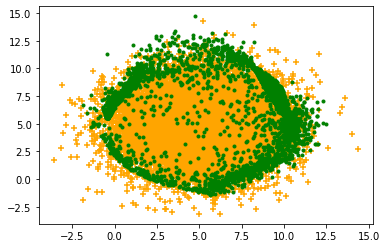

In [73]:
test_noise = np.random.normal(0, 1, (3000, 2))
test_fake_data = wgan.generator.predict(test_noise)

plt.scatter(train_normal_data[:, 0], train_normal_data[:, 1], c='orange',  marker='+')
plt.scatter(test_fake_data[:, 0],    test_fake_data[:, 1],    c='green', marker='.')
plt.show()

###### 测试集可视化

In [68]:
scores = model.predict(test_data_x)
test_out = np.int64(scores>=norm.ppf(0.999))
conf_mat = classification_report(test_data_y, test_out, target_names=['benign', 'vandal'], digits=4)
print(conf_mat)
cm = confusion_matrix(test_data_y, test_out, labels=[0, 1])
m = list(filter(None, conf_mat.strip().split(" ")))
precision, recall, threshold = precision_recall_curve(test_data_y, scores)
pr_auc = auc(recall, precision) 
res = [cm[0][0],cm[0][1],cm[1][0],cm[1][1],roc_auc_score(test_data_y,scores),pr_auc,np.sqrt(float(m[6])*float(m[11]))]
print(res)

              precision    recall  f1-score   support

      benign     0.9995    0.9778    0.9885     15000
      vandal     0.2517    0.9333    0.3965       120

    accuracy                         0.9774     15120
   macro avg     0.6256    0.9556    0.6925     15120
weighted avg     0.9935    0.9774    0.9838     15120

[14667, 333, 8, 112, 0.9911133333333334, 0.3699350766883006, 0.9552909190398493]


In [69]:
true_positive_index = np.where((test_data_y == 1))[0]
true_negative_index = np.where((test_data_y == 0))[0]
print(true_positive_index.shape,true_negative_index.shape)
predict_positive_index = np.where((test_out == 1))[0]
test_FP_index = []
test_TP_index = []
for i in predict_positive_index:
    if i not in true_positive_index:
        test_FP_index.append(i)
    else:
        test_TP_index.append(i)
print(len(test_FP_index),len(test_TP_index))

predict_negative_index = np.where((test_out == 0))[0]
test_FN_index = []
test_TN_index = []
for i in predict_negative_index:
    if i not in true_negative_index:
        test_FN_index.append(i)
    else:
        test_TN_index.append(i)
print(len(test_FN_index),len(test_TN_index))

(120,) (15000,)
333 112
8 14667


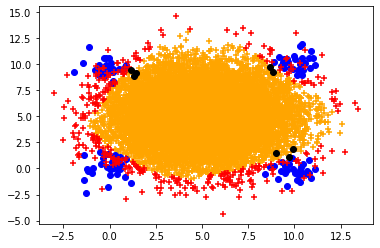

In [70]:
plt.scatter(test_data_x[test_TN_index, 0], test_data_x[test_TN_index, 1], c='orange',  marker='+')
plt.scatter(test_data_x[test_TP_index, 0], test_data_x[test_TP_index, 1], c='blue',  marker='o')
plt.scatter(test_data_x[test_FP_index, 0], test_data_x[test_FP_index, 1], c='red',  marker='+')
plt.scatter(test_data_x[test_FN_index, 0], test_data_x[test_FN_index, 1], c='black',  marker='o')
plt.show()